In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [3]:
pwd

'/Users/amnon/git/dbbact-paper/notebooks/human-nasopharynx-children-strep-22-02-23'

In [4]:
ca.set_log_level(11)

In [5]:
%matplotlib inline

In [6]:
db=ca.database._get_database_class('dbbact')

creating logger


In [7]:
# use the amnon calour config file
import os
os.environ['CALOUR_CONFIG_FILE']='/Users/amnon/git/calour/calour/calour.config.amnon'

# Load the dataset
from:

Nasopharyngeal microbiome composition associated with Streptococcus pneumoniae colonization suggests a protective role of Corynebacterium in young children

Xu, L., Earl, J., & Pichichero, M. E. (2021). Plos one, 16(9), e0257207.

https://doi.org/10.1371/journal.pone.0257207

In [8]:
dat=ca.read_amplicon('./all.biom','./map.txt',normalize=10000,min_reads=1000)

2022-06-30 17:12:04 INFO loaded 157 samples, 3820 features
2022-06-30 17:12:04 WARNING Do you forget to normalize your data? It is required before running this function
2022-06-30 17:12:04 INFO After filtering, 153 remain.


# Preprocess
Cluster the features (filtering features with <10 reads total over all samples)

Sort by antibiotics and strep. presence

In [9]:
datc=dat.cluster_features(10)

2022-06-30 17:12:04 INFO After filtering, 1603 remain.


In [10]:
datc=datc.sort_samples('Abx')
datc=datc.sort_samples('Spn')

# Looking at the data and manually examining the clusters, we see a large cluster with mice associated bacteria

In [11]:
cu.splot(datc,'Age',barx_fields=['Abx','Spn'])

/Users/amnon/git/calour/calour/heatmap/heatmap.py:308: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(bad_color)


# Also in the wordcloud, a lot of mouse association

2022-06-30 17:12:08 INFO After filtering, 65 remain.
2022-06-30 17:12:08 INFO Getting dbBact annotations for 65 sequences, please wait...
2022-06-30 17:12:11 INFO got 4047 annotations
2022-06-30 17:12:11 INFO Got 16629 annotation-sequence pairs
2022-06-30 17:12:11 INFO Added annotation data to experiment. Total 4047 annotations, 65 ASVs


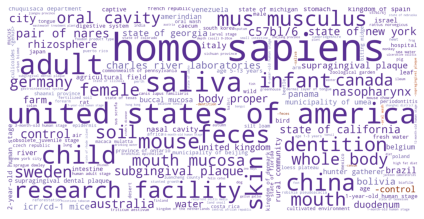

In [12]:
f=db.draw_wordcloud(datc.filter_prevalence(0.3))

In [13]:
f.savefig('./fig-wordcloud-all.pdf',dpi=600)

# lets find the most relevant term for each feature

out of the list of expected ('homo sapiens', 'Saliva', 'Nasopharynx') and possible contaminants ('mus musculus','water','soil')

In [14]:
tt=datc.add_terms_to_features('dbbact',['homo sapiens', 'Saliva', 'Nasopharynx', 'mus musculus','water','soil'])

2022-06-30 17:12:23 INFO Getting dbBact annotations for 1603 sequences, please wait...
2022-06-30 17:12:30 INFO got 6064 annotations
2022-06-30 17:12:31 INFO Got 119020 annotation-sequence pairs
2022-06-30 17:12:31 INFO Added annotation data to experiment. Total 6064 annotations, 1603 ASVs


In [15]:
tt=tt.sort_by_metadata('common_term',axis='f')

In [16]:
cu.splot(tt,'Age',barx_fields=['Abx','Spn'],bary_fields=['common_term'])

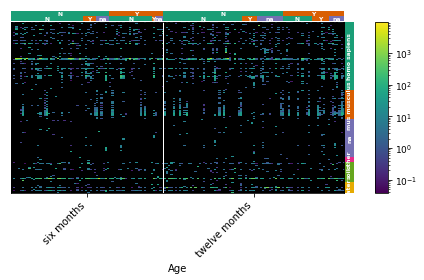

In [17]:
f=tt.sort_samples('Age').plot(sample_field='Age',barx_fields=['Abx','Spn'],bary_fields=['common_term'])

In [18]:
f.save_figure('./fig-heatmap-with-terms.pdf',dpi=600)

# Let's do it with less terms for the paper figure

In [19]:
tt=datc.add_terms_to_features('dbbact',['homo sapiens', 'mus musculus','soil'])

In [20]:
tt=tt.sort_by_metadata('common_term',axis='f')

/Users/amnon/git/calour/calour/heatmap/heatmap.py:308: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(bad_color)


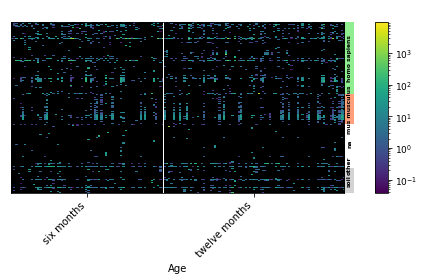

In [21]:
f=tt.sort_samples('Age').plot(sample_field='Age',bary_fields=['common_term'],bary_colors={'other':'white','na':'white','soil':'lightgrey','homo sapiens':'lightgreen','mus musculus':'lightsalmon'},bary_label_kwargs={'color':'black'})

In [22]:
f.save_figure('./fig-heatmap-with-terms-simple.pdf',dpi=600)

# Increased sensitivity following filtering of contaminants

In [23]:
datc

AmpliconExperiment with 153 samples, 1603 features

In [24]:
nomouse = tt.filter_by_metadata('common_term',['mus musculus'],negate=True,axis='f').normalize().cluster_features(10)
nomouse

2022-06-30 17:14:48 INFO After filtering, 1320 remain.


AmpliconExperiment with 153 samples, 1320 features

In [25]:
nocontam = tt.filter_by_metadata('common_term',['mus musculus','soil'],negate=True,axis='f').normalize().cluster_features(10)
nocontam

2022-06-30 17:14:53 INFO After filtering, 1093 remain.


AmpliconExperiment with 153 samples, 1093 features

In [28]:
import skbio

In [42]:
nomouse.sample_metadata['shannon diversity']=skbio.diversity.alpha_diversity('shannon',nomouse.get_data(sparse=False)).values
nocontam.sample_metadata['shannon diversity']=skbio.diversity.alpha_diversity('shannon',nocontam.get_data(sparse=False)).values
datc.sample_metadata['shannon diversity']=skbio.diversity.alpha_diversity('shannon',datc.get_data(sparse=False)).values

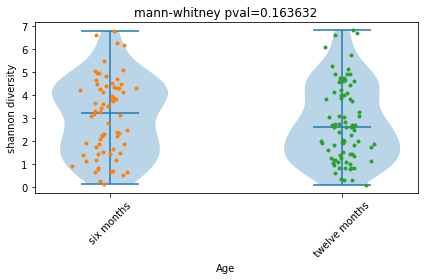

In [48]:
labels,data,f=cu.plot_violin_category(datc,'Age','shannon diversity',xlabel_params={'rotation':45})
res=sp.stats.mannwhitneyu(data[0],data[1])
plt.title('mann-whitney pval=%f' % res[1])
plt.tight_layout()
f.savefig('./fig-alpha-shannon-all.pdf')

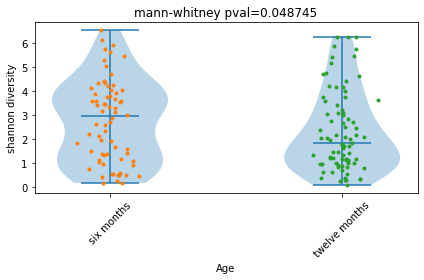

In [49]:
labels,data,f=cu.plot_violin_category(nocontam,'Age','shannon diversity',xlabel_params={'rotation':45})
res=sp.stats.mannwhitneyu(data[0],data[1])
plt.title('mann-whitney pval=%f' % res[1])
plt.tight_layout()
f.savefig('./fig-alpha-shannon-nocontam.pdf')